## Disclaimer
This ipynb has an important conceptual mistake that was intentionally introduced. The objective is that students discover the mistake and solve the implementation problem. Use with caution!

In [1]:
import pandas as pd
import numpy as np
from os import path
from sklearn import preprocessing, model_selection, metrics
# import tensorflow as tf
import keras
import matplotlib.pyplot as plt


# Data location

In [4]:
# Walking with the smatphone in the right hand
source_path_hand = r'C:\Users\joses\Mi unidad\Docencia\fing\Mecatronica\Inteligencia Artificial II\repo\iaii\pocket_hand\raw_data\hand'

# Standing with the smartphone in the right hand
source_path_standing = r'C:\Users\joses\Mi unidad\Docencia\fing\Mecatronica\Inteligencia Artificial II\repo\iaii\pocket_hand\raw_data\right'

# Standing with the smartphone in the pocket
source_path_pocket = r'C:\Users\joses\Mi unidad\Docencia\fing\Mecatronica\Inteligencia Artificial II\repo\iaii\pocket_hand\raw_data\pocket'

acc_filename = 'AccelerometerUncalibrated.csv'

# File reading

blue > standing
red > pocket
green > hand


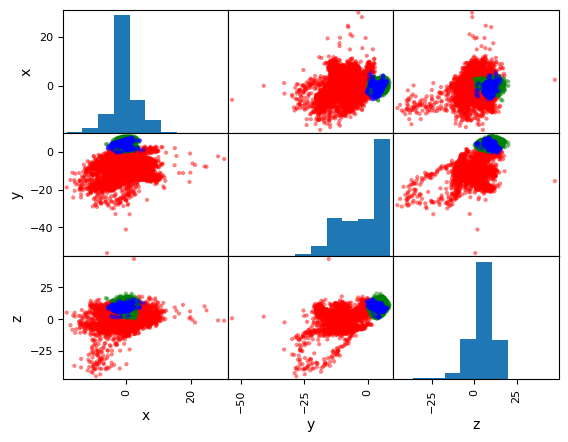

In [5]:
pocket_df = pd.read_csv(path.join(source_path_pocket, acc_filename))
hand_df = pd.read_csv(path.join(source_path_hand, acc_filename))
standing_df = pd.read_csv(path.join(source_path_standing, acc_filename))


# pd.plotting.scatter_matrix(pocket_df.loc[:, ['x', 'y', 'z']])
# pd.plotting.scatter_matrix(hand_df.loc[:, ['x', 'y', 'z']])
# pd.plotting.scatter_matrix(standing_df.loc[:, ['x', 'y', 'z']])

color_wheel = {1: "blue", 
               2: "red", 
               3: "green"}
full_df = pd.concat((pocket_df, hand_df, standing_df))
colors = np.vectorize(lambda x: color_wheel[x+1])(np.hstack((1+np.zeros(pocket_df.shape[0]), 2+np.zeros(hand_df.shape[0]), 0+np.zeros(standing_df.shape[0]))))
pd.plotting.scatter_matrix(full_df.loc[:, ['x', 'y', 'z']], color=colors)
print('blue > standing')
print('red > pocket')
print('green > hand')

# Dataset generation

In [6]:
fs = 1/(hand_df.loc[1, 'seconds_elapsed'] - hand_df.loc[0, 'seconds_elapsed'])

window_length_s = 5
window_length = int(fs*window_length_s)

X_pocket = []
for i in range(pocket_df.shape[0]-window_length-1):
    X_pocket.append(np.hstack((pocket_df.loc[i:i+window_length, 'x'].values,
                             pocket_df.loc[i:i+window_length, 'y'].values,
                             pocket_df.loc[i:i+window_length, 'z'].values)))
X_pocket = np.array(X_pocket)

X_hand = []
for i in range(hand_df.shape[0]-window_length-1):
    X_hand.append(np.hstack((hand_df.loc[i:i+window_length, 'x'].values,
                              hand_df.loc[i:i+window_length, 'y'].values,
                              hand_df.loc[i:i+window_length, 'z'].values)))
X_hand = np.array(X_hand)

X_standing = []
for i in range(standing_df.shape[0]-window_length-1):
    X_standing.append(np.hstack((standing_df.loc[i:i+window_length, 'x'].values,
                             standing_df.loc[i:i+window_length, 'y'].values,
                             standing_df.loc[i:i+window_length, 'z'].values)))
X_standing = np.array(X_standing)


## One hot encoding

In [7]:
y_hand = 1+np.zeros((X_hand.shape[0], 1))
y_pocket = 2+np.zeros((X_pocket.shape[0], 1))
y_standing = np.zeros((X_standing.shape[0], 1))

y_numbers = np.vstack((y_hand, y_pocket, y_standing))
X_lrn = np.vstack((X_hand, X_pocket, X_standing))

# scaler = preprocessing.MinMaxScaler()
# scaler.fit(X_lrn)
# X = scaler.transform(X_lrn)
X = X_lrn

encoder = preprocessing.OneHotEncoder(sparse_output=False)

y = encoder.fit_transform(y_numbers)

print(X.shape, y.shape)

(7486, 1506) (7486, 3)


## Train test split

In [24]:

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, shuffle=True)

In [25]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(5988, 1506) (5988, 3) (1498, 1506) (1498, 3)


# Neural network

In [26]:
# x_input = keras.layers.Input(shape=X.shape[1])
# x = keras.layers.Dense(4, activation='relu')(x_input)
# x = keras.layers.Dense(2, activation='relu')(x)
# x_output = keras.layers.Dense(3, activation='softmax')(x)

regularizer = keras.regularizers.l2(0.01)
x_input = keras.layers.Input(shape=X.shape[1])
# x = keras.layers.Reshape((X.shape[1], 1))(x_input)
x = keras.layers.Reshape((X.shape[1]//3, 3))(x_input)
x = keras.layers.Conv1D(filters=1, activation='tanh', kernel_size=100, strides=1, kernel_regularizer=regularizer)(x)
# x = keras.layers.MaxPooling1D(20)(x)
# x = keras.layers.Dense(3, activation='relu')(x)
x = keras.layers.Flatten()(x)
x_output = keras.layers.Dense(3, activation='softmax')(x)

model = keras.Model(inputs=x_input, outputs=x_output)

model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1506)]            0         
                                                                 
 reshape_2 (Reshape)         (None, 502, 3)            0         
                                                                 
 conv1d_2 (Conv1D)           (None, 403, 1)            301       
                                                                 
 flatten_2 (Flatten)         (None, 403)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 1212      
                                                                 
Total params: 1513 (5.91 KB)
Trainable params: 1513 (5.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


Epoch 1/10
479/479 [==============================] - 9s 13ms/step - loss: 0.0905 - accuracy: 0.9810 - precision_2: 0.9818 - val_loss: 0.0274 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - lr: 0.0100
Epoch 2/10
479/479 [==============================] - 6s 12ms/step - loss: 0.0199 - accuracy: 1.0000 - precision_2: 1.0000 - val_loss: 0.0184 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - lr: 0.0100
Epoch 3/10
479/479 [==============================] - 6s 12ms/step - loss: 0.0142 - accuracy: 1.0000 - precision_2: 1.0000 - val_loss: 0.0137 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - lr: 0.0100
Epoch 4/10
479/479 [==============================] - 5s 11ms/step - loss: 0.0113 - accuracy: 1.0000 - precision_2: 1.0000 - val_loss: 0.0110 - val_accuracy: 1.0000 - val_precision_2: 1.0000 - lr: 0.0100
Epoch 5/10
479/479 [==============================] - 7s 15ms/step - loss: 0.0093 - accuracy: 1.0000 - precision_2: 1.0000 - val_loss: 0.0092 - val_accuracy: 1.0000 - val_precision_2: 

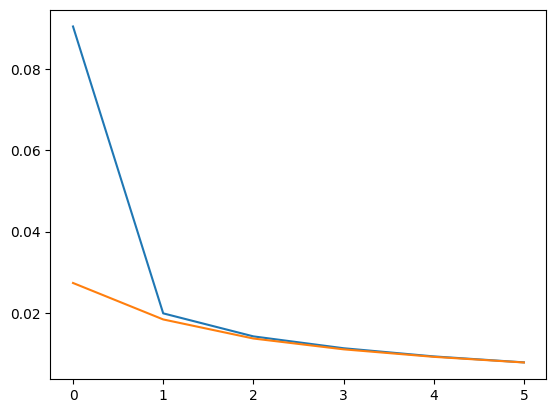

In [27]:

batch_size = 10 # X_train.shape[0] # 100
lr = 0.01
epochs = 10
# momentum = 0.1

red_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.7)
early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)


model.compile(optimizer=keras.optimizers.SGD(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy', keras.metrics.Precision(thresholds=0.5)])


history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2, callbacks=[red_lr, early_stop])


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


input_3
reshape_2
conv1d_2
<keras.src.layers.convolutional.conv1d.Conv1D object at 0x000001F1816E3610> (100, 3, 1) (1,)


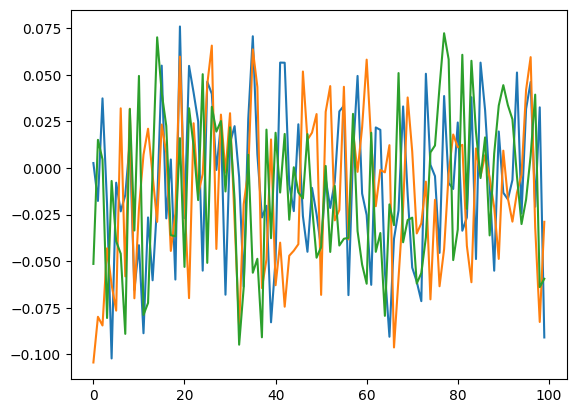

In [28]:
# learned kernels
for layer in model.layers:
    print(layer.name)
    if layer.name[:4] == 'conv':
        break

if layer.name[:4] == 'conv': 
    print(layer, layer.weights[0].shape, layer.weights[1].shape)
    plt.plot(np.array(layer.weights[0]).reshape((-1, layer.weights[0].shape[1]*layer.weights[0].shape[2])))

# Test

47/47 [==============================] - 0s 5ms/step - loss: 0.0072 - accuracy: 1.0000 - precision_2: 1.0000
Loss: 0.007280259858816862 Accuracy: 1.0 
 Train Loss: 0.007290812209248543 Train Accuracy: 1.0 
 Test Loss: 0.007238063961267471 Test Accuracy: 1.0


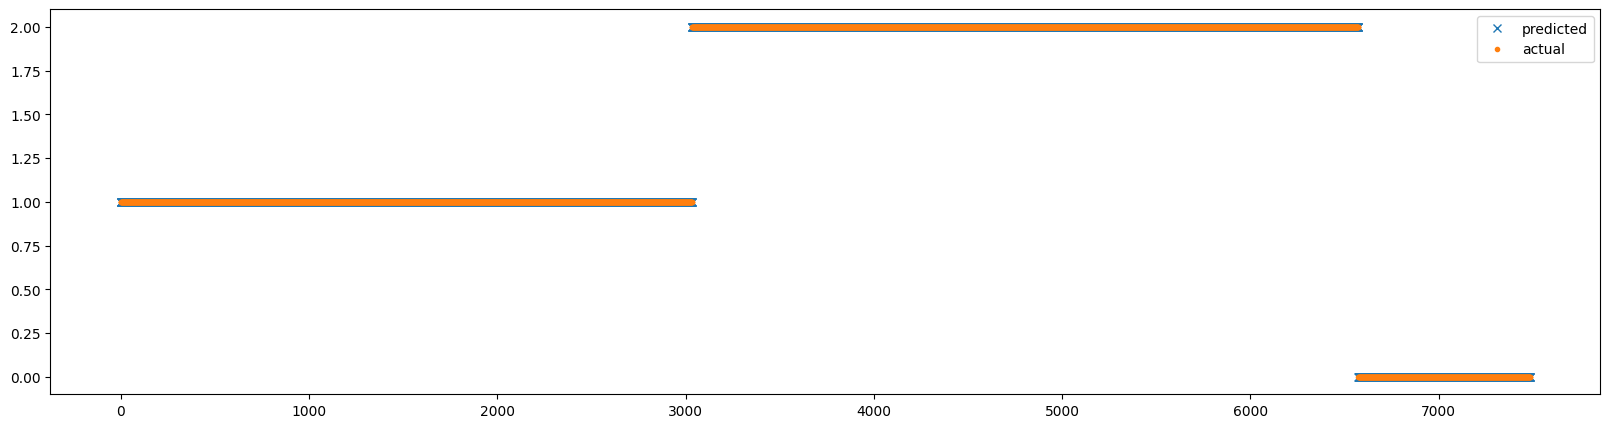

In [29]:
y_probabilities = model.predict(X)

 # Convert probabilities to class indices
y_pred_classes = np.argmax(y_probabilities, axis=1)

plt.figure(figsize=(20,5))
plt.plot(y_pred_classes, linestyle='none', marker='x', label='predicted')
plt.plot(encoder.inverse_transform(y), linestyle='none', marker='.', label='actual')
plt.legend()

loss, accuracy, precision = model.evaluate(X, y)
train_loss, train_accuracy, train_precision = model.evaluate(X_train, y_train)
test_loss, test_accuracy, test_accuracy = model.evaluate(X_test, y_test)


print("Loss:", loss, "Accuracy:", accuracy, '\n',
      "Train Loss:", train_loss, "Train Accuracy:", train_accuracy, '\n', 
      "Test Loss:", test_loss, "Test Accuracy:", test_accuracy)



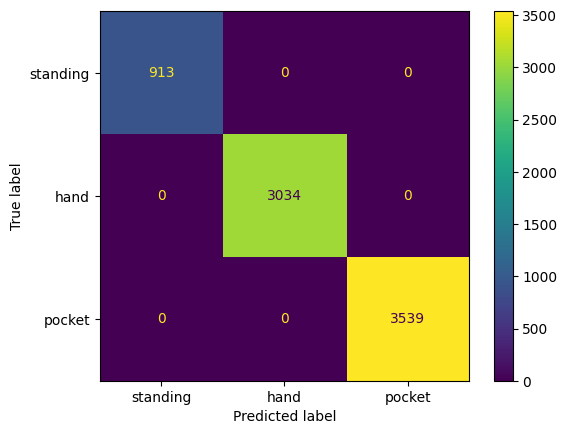

In [30]:
cm = metrics.confusion_matrix(encoder.inverse_transform(y), y_pred_classes)
metrics.ConfusionMatrixDisplay(cm, display_labels=['standing', 'hand', 'pocket']).plot()

47/47 [==============================] - 0s 7ms/step


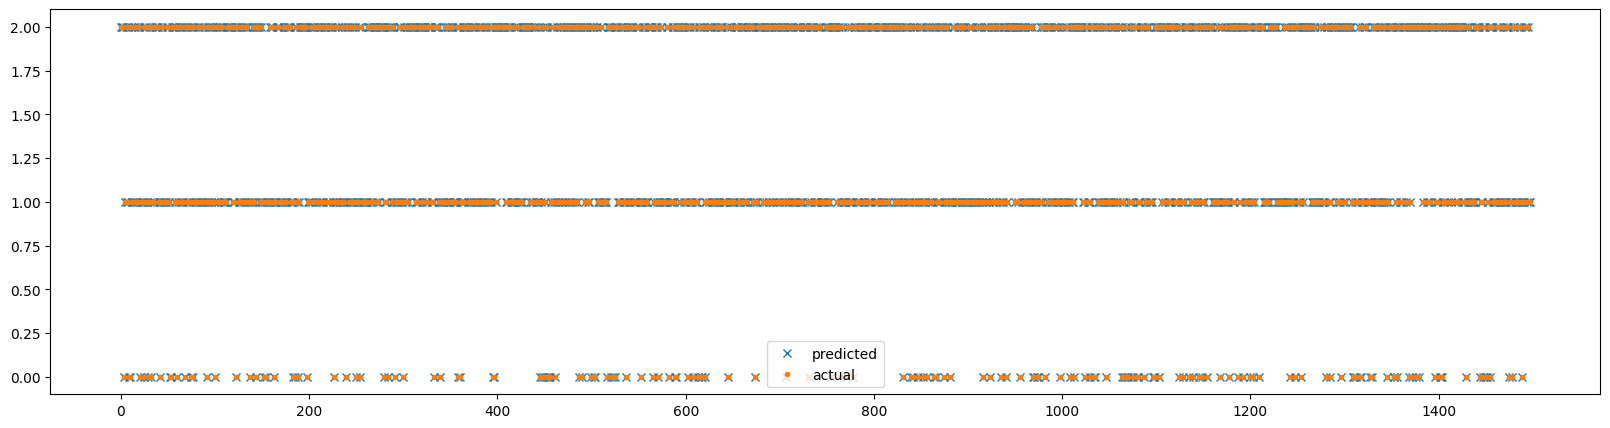

In [31]:
y_test_probabilities = model.predict(X_test)

 # Convert probabilities to class indices
y_test_pred_classes = np.argmax(y_test_probabilities, axis=1)

plt.figure(figsize=(20,5))
plt.plot(y_test_pred_classes, linestyle='none', marker='x', label='predicted')
plt.plot(encoder.inverse_transform(y_test), linestyle='none', marker='.', label='actual')
plt.legend()
